## Metric (FID, SSIM, L2, LSISP)

In [ ]:
!pip install transformers
!pip install --upgrade diffusers[torch]
!pip install accelerate
!pip install torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
import os
import pathlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
import easydict

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


In [ ]:
def init_seeds(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:224'

init_seeds(9222)

preprocess_tensor = TF.Compose([
    TF.ToTensor(),
])


In [ ]:
# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'  # noqa: E501


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=(DEFAULT_BLOCK_INDEX,),
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(weights='DEFAULT')

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`"""
    try:
        version = tuple(map(int, torchvision.__version__.split('.')[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    # Skips default weight inititialization if supported by torchvision
    # version. See https://github.com/mseitzer/pytorch-fid/issues/28.
    if version >= (0, 6):
        kwargs['init_weights'] = False

    # Backwards compatibility: `weights` argument was handled by `pretrained`
    # argument prior to version 0.13.
    if version < (0, 13) and 'weights' in kwargs:
        if kwargs['weights'] == 'DEFAULT':
            kwargs['pretrained'] = True
        elif kwargs['weights'] is None:
            kwargs['pretrained'] = False
        else:
            raise ValueError(
                'weights=={} not supported in torchvision {}'.format(
                    kwargs['weights'], torchvision.__version__
                )
            )
        del kwargs['weights']

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008,
                              aux_logits=False,
                              weights=None)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


In [ ]:
import os
import pathlib
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser

import numpy as np
import torch
import torchvision.transforms as TF
from PIL import Image
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

try:
    from tqdm import tqdm
except ImportError:
    # If tqdm is not available, provide a mock version of it
    def tqdm(x):
        return x

# from pytorch_fid.inception import InceptionV3




IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}


class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        return img


def get_activations(files, model, batch_size=50, dims=2048, device='cpu',
                    num_workers=1):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    # if batch_size > len(files):
    #     print(('Warning: batch size is bigger than the data size. '
    #            'Setting batch size to data size'))
    #     batch_size = len(files)

    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             drop_last=False,
                                             num_workers=num_workers)

    pred_arr = np.empty((len(files), dims))

    start_idx = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx:start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50, dims=2048,
                                    device='cpu', num_workers=1):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    -- num_workers : Number of parallel dataloader workers

    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, device, num_workers)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def compute_statistics_of_path(path, model, batch_size, dims, device,
                               num_workers=1):
    if path.endswith('.npz'):
        with np.load(path) as f:
            m, s = f['mu'][:], f['sigma'][:]
    else:
        # breakpoint()
        path = pathlib.Path(path)
        files = [path]
        # files = sorted([file for ext in IMAGE_EXTENSIONS
        #                for file in path.glob('*.{}'.format(ext))])
        # breakpoint()
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, device, num_workers)

    return m, s


def calculate_fid_given_paths(paths, batch_size, device, dims, num_workers):
    """Calculates the FID of two paths"""
    # for p in paths:
    #     if not os.path.exists(p):
    #         raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
                                        dims, device, num_workers)
    m2, s2 = compute_statistics_of_path(paths[1], model, batch_size,
                                        dims, device, num_workers)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value



In [ ]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details
from diffusers import StableDiffusionImg2ImgPipeline
to_pil = TF.ToPILImage()
preprocess_tensor_pil= TF.ToPILImage()

model_id_or_path = "runwayml/stable-diffusion-v1-5"
# model_id_or_path = "CompVis/stable-diffusion-v1-4"
# model_id_or_path = "CompVis/stable-diffusion-v1-3"
# model_id_or_path = "CompVis/stable-diffusion-v1-2"
# model_id_or_path = "CompVis/stable-diffusion-v1-1"
os.environ['HF_HUB_OFFLINE']='True'

pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id_or_path,
    revision="fp16",
    torch_dtype=torch.float16,
    cache_dir = "/content/drive/MyDrive/MajorProject/Diffusers_cache_test/"
)
device = 'cuda'
pipe_img2img = pipe_img2img.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:270: FutureWarning: You are loading the variant fp16 from runwayml/stable-diffusion-v1-5 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
import math
import sklearn.metrics
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch import linalg as LA
import numpy as np
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity


# class metric:
w = 1/3

def free_memory(model):
  del model
  torch.cuda.empty_cache()

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


def ssim(im1, im2):
    w1 = w2 = w3 = 1/3
    ssim_value = 0
    for i in range(im1.shape[0]):
        ssim_value += w*compare_ssim(im1[i] , im2[i] , gaussian_weights=True, sigma=1.5, data_range=255)

    return ssim_value

def l2(im1, im2):
    return LA.vector_norm(im1-im2)
    # return (im1-im2).norm()

def calculate_psnr(original_img, processed_img, max_pixel_value):


#         # Convert images to float for accurate calculations
#         original_image = original_image.astype(np.float64)
#         processed_image = processed_image.astype(np.float64)
    # mse = np.mean((original_img - processed_img) ** 2)
    # psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    psnr_val = psnr(original_img, processed_img)
    return psnr_val


def get_metrics(images_to_compute, model, path_to_folder, num_of_images,  SEED, name):
  '''Get name of all the images'''
  QFs = [25, 35, 45, 55, 65, 75, 85]

  '''Perform Append operation here'''

  metric = torch.tensor([])

  for i in range(num_of_images):
    if i in images_to_compute:
      name_img_path = [] # would contain name of images

      for qf in QFs:
        name_img_path.append(f'{path_to_folder}/{i}/gen_adv_image{qf}.png')

      name_img_path.append(f'{path_to_folder}/{i}/gen_adversarial.png')

      original_image = f'{path_to_folder}/{i}/gen_original_image.png'
      init_image = Image.open(original_image)
      init_image = preprocess_tensor(init_image)


      #torch.empty((num_of_images,len(name_img_path)) )# would contain metrics for all the QFs
      intermit_values = []

      if name=="psnr":
        init_image_np = np.uint8(init_image.numpy()*255)  #check value here (Typecast to uint8)
        for num_img, image in enumerate(name_img_path):
          image_pil = Image.open(image)
          image_np = np.transpose(np.array(image_pil),(2,0,1))  #Check for range of value

          psnr = calculate_psnr(init_image_np, image_np, max_pixel_value = 255)
          intermit_values.append(psnr)

        intermit_tensor = torch.from_numpy(np.array(intermit_values)).unsqueeze(0)
        metric = torch.cat((metric, intermit_tensor), 0)



      elif name == "l2_latent":

        # with torch.autocast('cuda'):

        torch.manual_seed(SEED)
        image_p = preprocess(preprocess_tensor_pil(init_image)).half().to(device)
        x_latent = model(image_p).latent_dist.mean
        x_latent = x_latent.detach()

        for num_img, image in enumerate(name_img_path):
          image_adv_im = Image.open(image)
          image_tensor = preprocess(image_adv_im).half().to(device)
          torch.manual_seed(SEED)
          img_latent = model(image_tensor).latent_dist.mean
          img_latent = img_latent.detach()
          l2_latent = l2(x_latent, img_latent)
          intermit_values.append(l2_latent.cpu())
        intermit_tensor = torch.from_numpy(np.array(intermit_values)).unsqueeze(0)
        metric = torch.cat((metric, intermit_tensor), 0)

      elif name == "ssim":
        init_image_np = np.uint8(init_image.numpy()*255)  #check value here (Typecast)
        for num_img, image in enumerate(name_img_path):
          image_pil = Image.open(image)
          image_np = np.transpose(np.array(image_pil), (2,0,1))  #Check for range of value

          ssim_image = ssim(init_image_np, image_np)
          intermit_values.append(ssim_image)
        intermit_tensor = torch.from_numpy(np.array(intermit_values)).unsqueeze(0)
        metric = torch.cat((metric, intermit_tensor), 0)


      elif name == "fid":
        for num_img, image in enumerate(name_img_path):
          batch_size =  1
          dims =2048
          device_fid = 'cpu'
          paths = [original_image, image]
          fid_value = calculate_fid_given_paths(paths,
                                        batch_size,
                                        device_fid,
                                        dims,
                                        num_workers = 2
                                        )
          intermit_values.append(fid_value)
        intermit_tensor = torch.from_numpy(np.array(intermit_values)).unsqueeze(0)
        metric = torch.cat((metric, intermit_tensor), 0)


      elif name == "lpips":
        lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')
        init_image_scale = (init_image*2 -1).unsqueeze(0)

        for num_img, image in enumerate(name_img_path):
          image_tensor = preprocess_tensor(Image.open(image)).unsqueeze(0)
          image_scale = (image_tensor*2 -1)
          lpips_score = lpips(init_image_scale, image_scale)
          intermit_values.append(lpips_score.detach())

        intermit_tensor = torch.from_numpy(np.array(intermit_values)).unsqueeze(0) #(1*7(imgs_in_num_folder))
        metric = torch.cat((metric, intermit_tensor), 0)  #(folders(eg, 1, 2), 7(imgs_in_num_folder) )

  return metric


In [ ]:
import math
import sklearn.metrics
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch import linalg as LA
import numpy as np
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity


# class metric:
w = 1/3

def free_memory(model):
  del model
  torch.cuda.empty_cache()

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


def ssim(im1, im2):
    w1 = w2 = w3 = 1/3
    ssim_value = 0
    for i in range(im1.shape[0]):
        ssim_value += w*compare_ssim(im1[i] , im2[i] , gaussian_weights=True, sigma=1.5, data_range=255)

    return ssim_value

def l2(im1, im2):
    return LA.vector_norm(im1-im2)
    # return (im1-im2).norm()

def calculate_psnr(original_img, processed_img, max_pixel_value):


#         # Convert images to float for accurate calculations
#         original_image = original_image.astype(np.float64)
#         processed_image = processed_image.astype(np.float64)
    # mse = np.mean((original_img - processed_img) ** 2)
    # psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    psnr_val = psnr(original_img, processed_img)
    return psnr_val


def get_metrics(im1, im2, name):

  '''Perform Append operation here'''


    val = 0
    name_img_path = [] # would contain name of images

    init_image = Image.open(im1)
    init_image = preprocess_tensor(init_image)


    #torch.empty((num_of_images,len(name_img_path)) )# would contain metrics for all the QFs
    intermit_values = []

    if name=="psnr":
      init_image_np = np.uint8(init_image.numpy()*255)  #check value here (Typecast to uint8)
      image_pil = Image.open(im2)
      image_np = np.transpose(np.array(image_pil),(2,0,1))  #Check for range of value

      psnr = calculate_psnr(init_image_np, image_np, max_pixel_value = 255)

      val = psnr



    elif name == "l2_latent":

      # with torch.autocast('cuda'):

      torch.manual_seed(SEED)
      image_p = preprocess(preprocess_tensor_pil(init_image)).half().to(device)
      x_latent = model(image_p).latent_dist.mean
      x_latent = x_latent.detach()

      image_adv_im = Image.open(im2)
      image_tensor = preprocess(image_adv_im).half().to(device)
      torch.manual_seed(SEED)
      img_latent = model(image_tensor).latent_dist.mean
      img_latent = img_latent.detach()
      l2_latent = l2(x_latent, img_latent)
      val = l2_latent.cpu()

    elif name == "ssim":
      init_image_np = np.uint8(init_image.numpy()*255)  #check value here (Typecast)
      image_pil = Image.open(im2)
      image_np = np.transpose(np.array(image_pil), (2,0,1))  #Check for range of value

      ssim_image = ssim(init_image_np, image_np)
      val = ssim_image

    elif name == "fid":
      batch_size =  1
      dims =2048
      device_fid = 'cpu'
      paths = [im1, im2]
      fid_value = calculate_fid_given_paths(paths,
                                    batch_size,
                                    device_fid,
                                    dims,
                                    num_workers = 2
                                    )
      val =fid_value



    elif name == "lpips":
      lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')
      init_image_scale = (init_image*2 -1).unsqueeze(0)

      image_tensor = preprocess_tensor(Image.open(im2)).unsqueeze(0)
      image_scale = (image_tensor*2 -1)
      lpips_score = lpips(init_image_scale, image_scale)
      val = lpips_score.detach()

  return val


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(path_to_folder, metrics_val):

  fig, axs = plt.subplots(2,2 , figsize = (16,11))
  x = [25, 35, 45, 55, 65, 75, 85, 100]
  for i in range(metrics_val.size()[1]):   #total metrics; graphs
    for j in range(metrics_val.size()[0]):  #total images
      y = metrics_val[j, i, :].tolist()

      if (i==0 or i==1):
        roh_val = 0
      else:
        roh_val = 1

        # print(f'for {j}_th_image: {y}')
      axs[roh_val, i%2].plot(x,y, label = f"{j}")


      axs[roh_val,i%2].legend(loc='best')

    axs[roh_val, i%2].set_title(f'{metrics[i]}.', fontsize=16)



  for ax in axs.flat:
      ax.set(xlabel='QF', ylabel='value')

  # # Hide x labels and tick labels for top plots and y ticks for right plots.
  # for ax in axs.flat:
  #     ax.label_outer()

  plt.tight_layout()
  plt.savefig(f"{path_to_folder}/metric.png", bbox_inches='tight')
  plt.show()



In [ ]:
import csv
def write_csv(path_to_folder, metric_per_object_image ):
  x = ["",25, 35, 45, 55, 65, 75, 85, 100]
  with open(f"{path_to_folder}/metric.csv", "w") as file:
      writer = csv.writer(file)
      writer.writerow(x)

      for i in range(metric_per_object_image.size()[1]):  #metric wise
        vals_mean = []
        vals_std = []
        for j in range(metric_per_object_image.size()[2]): #QF wise
          vals_mean.append(metric_per_object_image[:, i, j].mean().numpy())
          vals_std.append(metric_per_object_image[:, i, j].std().numpy())

        vals_mean.insert(0, f"{metrics[i]}_mean")
        vals_std.insert(0, f"{metrics[i]}_std")
        writer.writerow(vals_mean)
        writer.writerow(vals_std)

In [ ]:
# folder_experiments_name = ["LAP0p01", "LAPEnsemble", "LPA0p005", "LPA0p02"]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 96.0MB/s]
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 243MB/s]
100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
<ipython-input-8-eb950c24b06f>:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


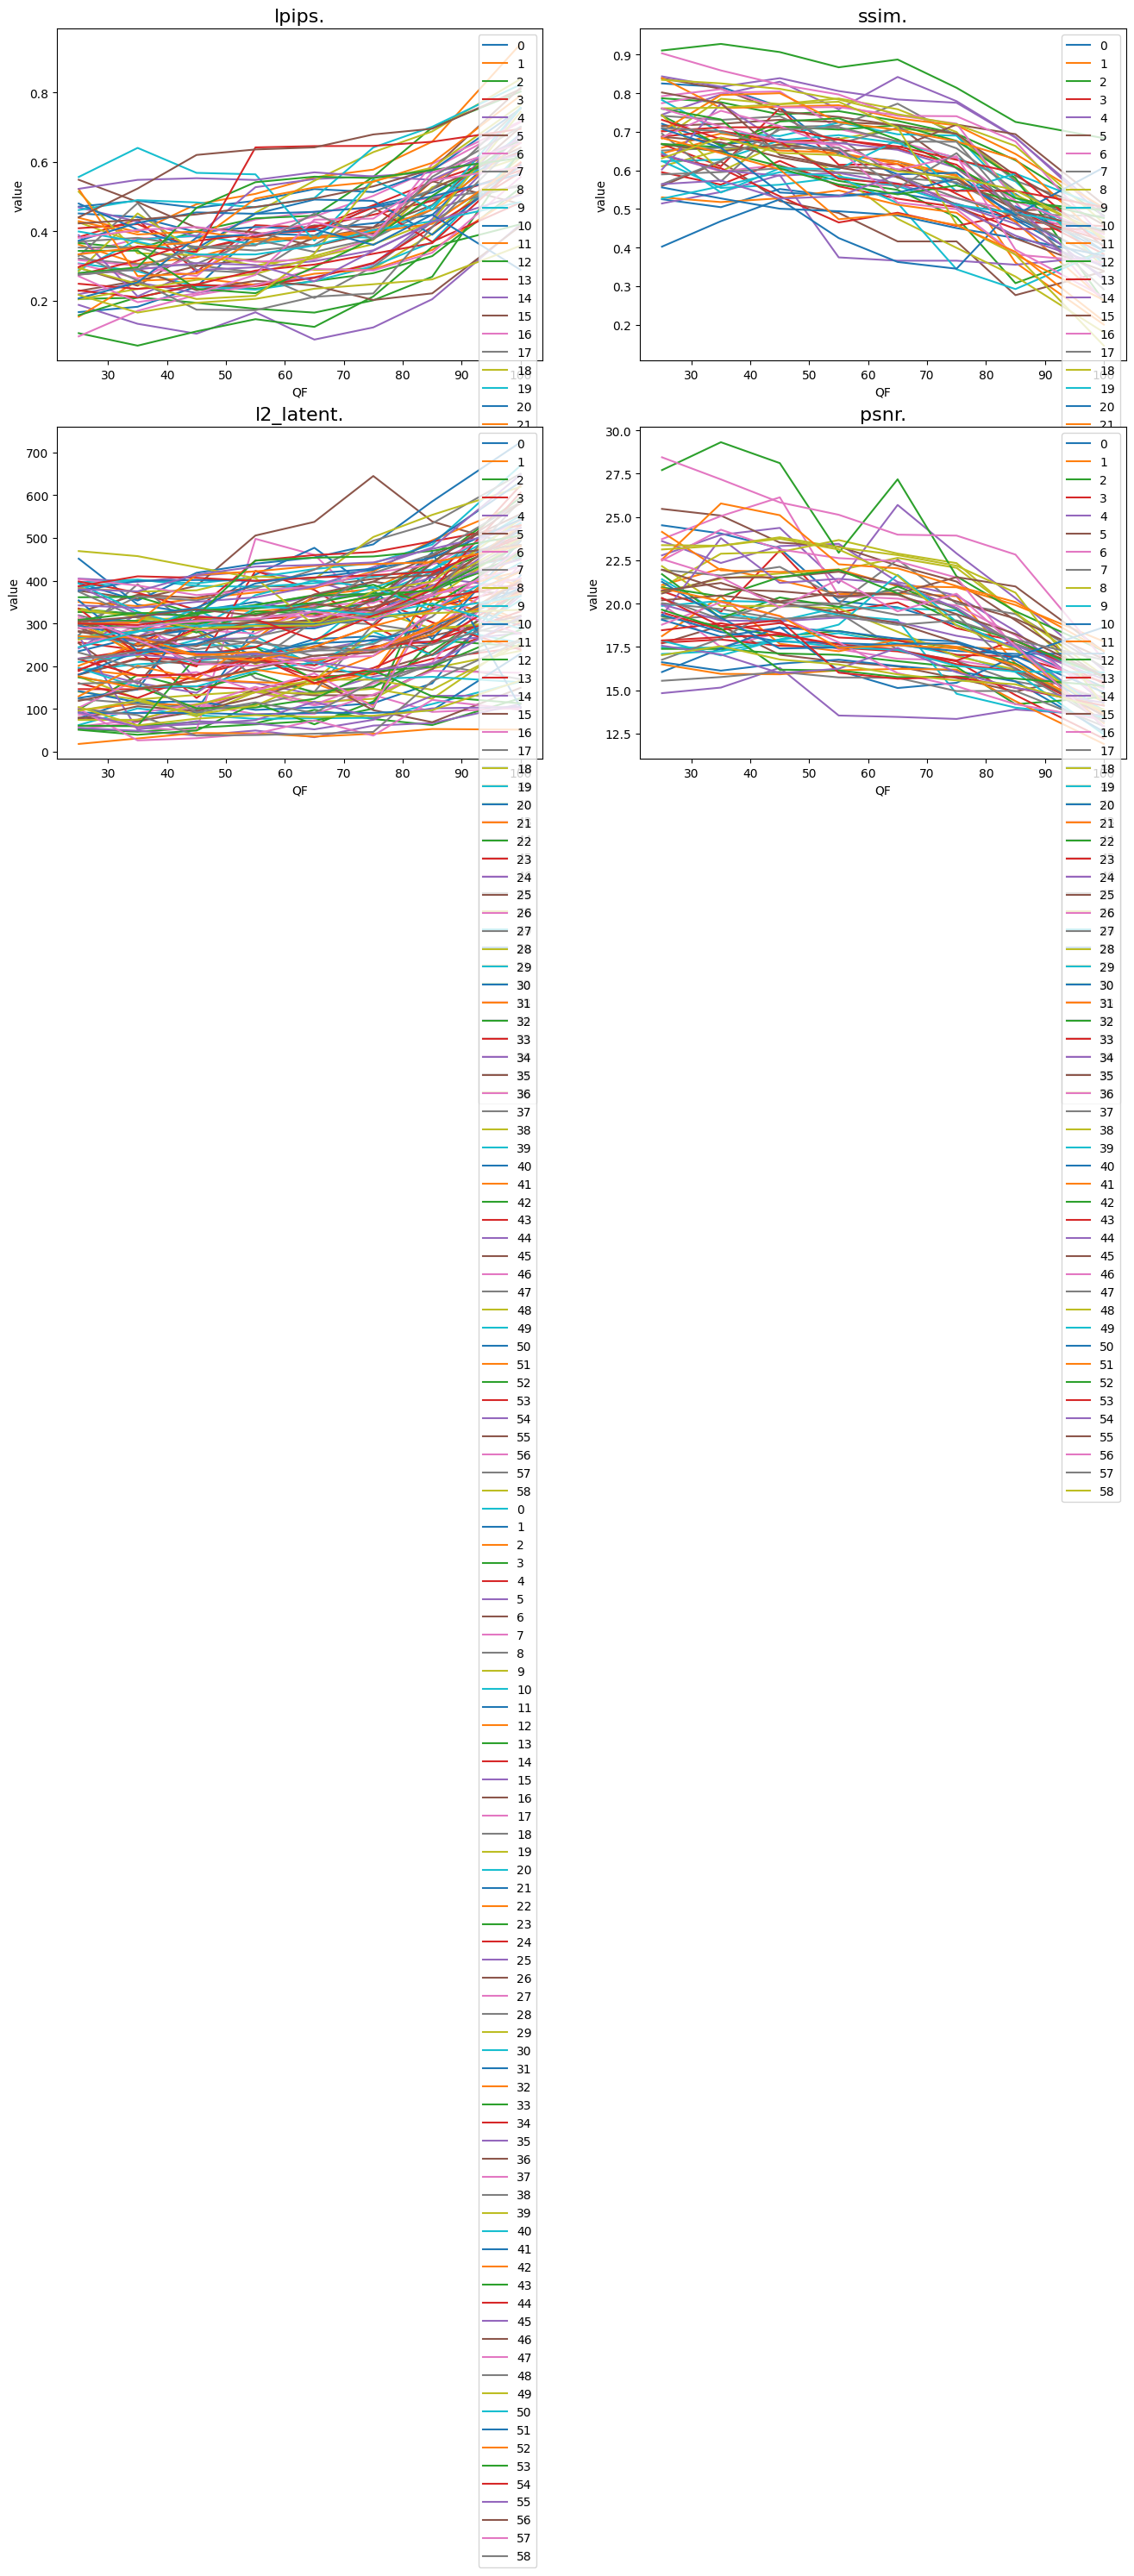

In [ ]:
metrics = ["lpips","ssim", "fid", "psnr", "l2_latent"]
# metrics = ["lpips","ssim"]
num_of_images = 60   #Change
not_doable = [52]
images_to_compute = [i  for i in range(60) if i not in not_doable]

SEED = 9222
model = pipe_img2img.vae.encode
folder_experiments_name = [ "EnsembleEncoder"]
nested_folder_name = ["All_ensemble_encoder"]
folder_name = "/content/drive/MyDrive/MajorProject/InstructPix2Pix"
for i, f_name in enumerate(folder_experiments_name):
  metric_per_object_image = torch.tensor([])
  path_to_folder = f"{folder_name}/{f_name}/{nested_folder_name[i]}"

  for m in metrics:
    val_QFs_m = get_metrics(images_to_compute, model, path_to_folder, num_of_images,  SEED, name = m)
    metric_per_object_image = torch.cat((metric_per_object_image, val_QFs_m.unsqueeze(0)), 0) # shape: Metrics*num_QFs*imgs_in_shape(2)

  metric_per_object_image = metric_per_object_image.permute((1,0,2))

  plot_graphs(path_to_folder, metric_per_object_image)
  write_csv(path_to_folder, metric_per_object_image)
  torch.save(metric_per_object_image,f"{path_to_folder}/results.pt" )

In [ ]:
# folder_experiments_name = ["Cat1000I", "FlowerPainting1000I", "VaseTarget1000I"]

In [ ]:
import csv
def write_csv(path_to_folder, metric_per_object_image ):
  x = ["",25, 35, 45, 55, 65, 75, 100]
  with open(f"{path_to_folder}/individual_file_result.csv", "w") as file:
      writer = csv.writer(file)
      writer.writerow(x)

      for k in range(metric_per_object_image.size()[0]):  #image wise

        for i in range(metric_per_object_image.size()[1]):  #metric wise
          vals= []
          for j in range(metric_per_object_image.size()[2]): #QF wise
            vals.append(metric_per_object_image[k, i, j].numpy())

          vals.insert(0, f"{k}_{metrics[i]}")
          writer.writerow(vals)


In [ ]:
write_csv(f'{path_to_folder}',metric_per_object_image )

In [ ]:
path_to_folder

'/content/drive/MyDrive/MajorProject/InstructPix2Pix/EnsembleEncoder/All_ensemble_encoder'

### Compute CLIP Similarity Score

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p6tl6u_h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p6tl6u_h
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 945.7 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=066a039d2ce83f3f85ceb80e4f594c28839a448e0216b23f84b838bf6b968f1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5okvnz1_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
def read_image_prompt(file_path):
  with open(file_path, 'r') as file:
    text = file.read()
  sentences = text.split('\n')
  image_url = []
  prompt = []
  for i, sentence in enumerate(sentences):
    if i%3==0:
      image_url.append(sentence)
    elif i%3==1:
      prompt.append(sentence)

  return (image_url, prompt)

file_path = '/content/drive/MyDrive/MajorProject/image_description.txt'
image_url, prompt = read_image_prompt(file_path)

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 155MiB/s]


In [ ]:


def get_clip_similatiry_score(path_to_folder, num_of_images,  SEED):
  '''Get name of all the images'''
  QFs = [25, 35, 45, 55, 65, 75, 85]

  '''Perform Append operation here'''

  metric = torch.tensor([])
  for i in range(num_of_images): #(Total Images)
    if i in not_doable:
      continue
    name_img_path = [] # contains name of images

    for qf in QFs:
      name_img_path.append(f'{path_to_folder}/{i}/gen_adv_image{qf}.png')

    name_img_path.append(f'{path_to_folder}/{i}/gen_adversarial.png')
    name_img_path.append(f'{path_to_folder}/{i}/gen_original_image.png')

    intermit_values = []  #(1, total_images_in_subfolder)

    for image in name_img_path:
      image = preprocess(Image.open(image)).unsqueeze(0).to(device)
      text = clip.tokenize(prompt[i]).to(device)

      with torch.no_grad():
          image_features = model.encode_image(image)
          text_features = model.encode_text(text)
          image_features /= image_features.norm(dim=-1, keepdim=True)
          text_features /= text_features.norm(dim=-1, keepdim=True)
          similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T #numpy
      intermit_values.append(similarity.squeeze(0).squeeze(0))
    intermit_tensor = torch.from_numpy(np.array(intermit_values)).unsqueeze(0)
    metric = torch.cat((metric, intermit_tensor), 0)

  return metric


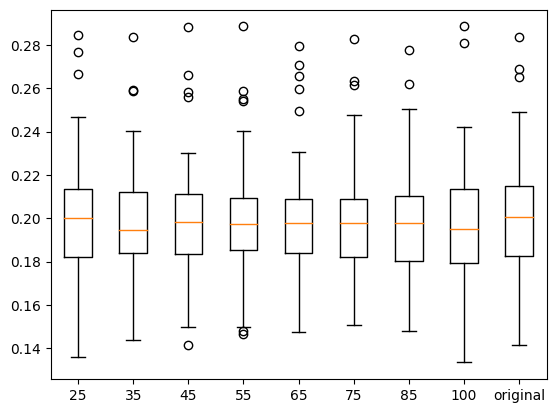

In [ ]:
import matplotlib.pyplot as plt
SEED = 9222
for i,f_name in enumerate(folder_experiments_name):

  total = torch.tensor([])
  path_to_folder = f"{folder_name}/{f_name}/{nested_folder_name[i]}"

  vals = get_clip_similatiry_score( path_to_folder, num_of_images,  SEED)
  torch.save(vals, f"{path_to_folder}/clip_scores.pt")
  all_data = []
  x_axis = [25,35,45,55,65,75,85,100, "original"]
  for i in range(vals.size()[1]): #Vals = (num_images_in_folder, num_images_in_subfolder)
    data = vals[:, i ]
    all_data.append(data)

  plt.boxplot(all_data, labels = x_axis)
  plt.savefig(f"{path_to_folder}/clip_scores_box_plt.png")
  plt.show()